In [53]:
import sklearn.preprocessing
import tensorboard
import tensorflow as tf
import numpy as np
import keras.backend

from packaging import version
from datetime import datetime
from linkmethods import get_target, get_backlink_views
from keras.layers import *

In [14]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.11.0


In [15]:
tensorboard.__version__

'2.11.0'

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [17]:
article = "Meisen"

In [18]:
df_main = get_target(article)

Directory already exists, reading in the file


In [19]:
bl_views = get_backlink_views(article, get_target(article))

Directory already exists, reading in the file
            views
timestamp        
2015070100    2.0
2015070200    0.0
2015070300    4.0
2015070400    4.0
2015070500    1.0
...           ...
2022062700    1.0
2022062800    3.0
2022062900    1.0
2022063000    0.0
2022070100    3.0

[2558 rows x 1 columns]
            views
timestamp        
2015070100    7.0
2015070200   10.0
2015070300    6.0
2015070400    7.0
2015070500   11.0
...           ...
2022062700    5.0
2022062800    9.0
2022062900   11.0
2022063000   14.0
2022070100    9.0

[2558 rows x 1 columns]
            views
timestamp        
2015070100   1678
2015070200   1719
2015070300   1764
2015070400   1876
2015070500   2426
...           ...
2022062700   2452
2022062800   2906
2022062900   2974
2022063000   2838
2022070100   1921

[2558 rows x 1 columns]
            views
timestamp        
2015070100    0.0
2015070200    0.0
2015070300    0.0
2015070400    0.0
2015070500    0.0
...           ...
2022062700    0.0
2022062800    0

In [20]:
roundoff = 10

In [21]:
roundeddata = []
for entry in bl_views:
    roundeddata.append((entry[:]//roundoff*roundoff)[-250:-1])
np.shape(roundeddata)

(162, 249)

In [22]:
roundeddata = np.array(roundeddata)

In [23]:
data = np.array(bl_views)[:,-250:-1]
print(data)
data.shape

[[0.000e+00 4.000e+00 3.000e+00 ... 3.000e+00 1.000e+00 0.000e+00]
 [8.000e+00 1.300e+01 1.300e+01 ... 9.000e+00 1.100e+01 1.400e+01]
 [4.460e+02 4.130e+02 3.860e+02 ... 2.906e+03 2.974e+03 2.838e+03]
 ...
 [6.400e+01 6.400e+01 6.700e+01 ... 9.300e+01 9.800e+01 8.000e+01]
 [3.690e+02 3.980e+02 4.080e+02 ... 1.920e+02 1.630e+02 1.350e+02]
 [1.000e+00 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]]


(162, 249)

In [76]:
target = np.array(df_main.views, dtype=float)[-250:-1]
target = np.array([np.copy(target) for _ in range((data.shape[0]))])
print(target)
target.shape

[[275. 281. 269. ... 192. 190. 180.]
 [275. 281. 269. ... 192. 190. 180.]
 [275. 281. 269. ... 192. 190. 180.]
 ...
 [275. 281. 269. ... 192. 190. 180.]
 [275. 281. 269. ... 192. 190. 180.]
 [275. 281. 269. ... 192. 190. 180.]]


(162, 249)

In [25]:
roundedtarget = target//roundoff*roundoff
np.shape(roundedtarget)

(162, 249)

In [26]:
roundedtarget = np.array(roundedtarget)

In [27]:
def round_activation(x):
  return tf.keras.backend.round(x/10)*10

In [54]:
a = tf.constant([1,2,3])
type(a)

tensorflow.python.framework.ops.EagerTensor

In [73]:
def smape(target, forecast):
    #target = tf.constant(target)
    #forecast = tf.constant(forecast)
    denominator = tf.abs(target) + tf.abs(forecast)
    flag = denominator == 0.
    if denominator == 0 :
        smape = tf.multiply(2, tf.divide(tf.multiply(tf.abs(target - forecast), (1 - flag)), 1))
    else :
        smape = tf.multiply(2, tf.divide(tf.multiply(tf.abs(target - forecast), (1 - flag)), 1))

    return smape

In [77]:
# Define the model.
model = keras.Sequential()

# 1 dense hidden layer with 250 nodes ~90+ acc
model.add(Input(shape=249)) # Input tensor
model.add(Dense(units=249)) # hidden layer 1,
model.add(Activation(activation="sigmoid"))

model.compile(
    optimizer='Adam',
    loss=smape,
    metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 249)               62250     
                                                                 
 activation_7 (Activation)   (None, 249)               0         
                                                                 
Total params: 62,250
Trainable params: 62,250
Non-trainable params: 0
_________________________________________________________________


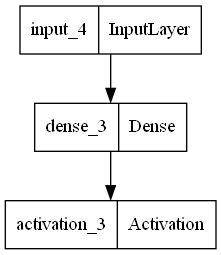

In [58]:
keras.utils.plot_model(model, "my_first_model.png")

In [30]:
roundeddata = (roundeddata-roundeddata.mean())/roundeddata.std()
roundedtarget = (roundedtarget-roundedtarget.mean())/roundedtarget.std()

In [31]:
roundeddata

array([[-0.1224281 , -0.1224281 , -0.1224281 , ..., -0.1224281 ,
        -0.1224281 , -0.1224281 ],
       [-0.1224281 , -0.11526724, -0.11526724, ..., -0.1224281 ,
        -0.11526724, -0.11526724],
       [ 0.19264949,  0.17116693,  0.14968436, ...,  1.95421963,
         2.00434561,  1.90409365],
       ...,
       [-0.07946297, -0.07946297, -0.07946297, ..., -0.05798041,
        -0.05798041, -0.06514126],
       [ 0.13536266,  0.15684522,  0.16400607, ...,  0.01362813,
        -0.00785443, -0.02933699],
       [-0.1224281 , -0.1224281 , -0.1224281 , ..., -0.1224281 ,
        -0.1224281 , -0.1224281 ]])

In [32]:
predata = sklearn.preprocessing.normalize(data,norm="l1")
pretarget = sklearn.preprocessing.normalize(target,norm="l1")
predata

array([[0.        , 0.00727273, 0.00545455, ..., 0.00545455, 0.00181818,
        0.        ],
       [0.00313725, 0.00509804, 0.00509804, ..., 0.00352941, 0.00431373,
        0.0054902 ],
       [0.00104952, 0.00097187, 0.00090833, ..., 0.00683837, 0.00699839,
        0.00667835],
       ...,
       [0.00261684, 0.00261684, 0.0027395 , ..., 0.00380259, 0.00400703,
        0.00327105],
       [0.00532952, 0.00574837, 0.0058928 , ..., 0.00277308, 0.00235423,
        0.00194982],
       [0.00293255, 0.00293255, 0.00293255, ..., 0.00293255, 0.00293255,
        0.00293255]])

In [78]:
from sklearn.model_selection import train_test_split

# Separate the test data
x, x_test, y, y_test = train_test_split(data, target, test_size=0.15, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)

In [81]:
x_train.shape

(116, 249)

In [82]:
y_train.shape

(116, 249)

In [83]:
# Train the model.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=50, restore_best_weights=True)
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=1500,
    validation_data=(x_val, y_val))

Epoch 1/1500


TypeError: in user code:

    File "C:\Users\Marvin\PycharmProjects\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Marvin\AppData\Local\Temp\ipykernel_32944\2772419595.py", line 7, in smape  *
        smape = tf.multiply(2, tf.divide(tf.multiply(tf.abs(target - forecast), (1 - flag)), (denominator + flag)))

    TypeError: Expected bool, but got 1 of type 'int'.


In [37]:
from matplotlib import pyplot as plt
def display_learning_curves(history):
    fig, axs = plt.subplots(2, 2, figsize=(19, 11))

    axs[0,0].plot(history.history["loss"])
    axs[0,0].legend(["train", "test"], loc="upper right")
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("Loss")

    axs[0,1].plot(history.history["accuracy"])
    axs[0,1].legend(["train", "test"], loc="upper right")
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Accuracy")

    axs[1,0].plot(history.history["val_loss"])
    axs[1,0].legend(["train", "test"], loc="upper right")
    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("val_loss")

    axs[1,1].plot(history.history["val_accuracy"])
    axs[1,1].legend(["train", "test"], loc="upper right")
    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("val_Accuracy")
    plt.show()

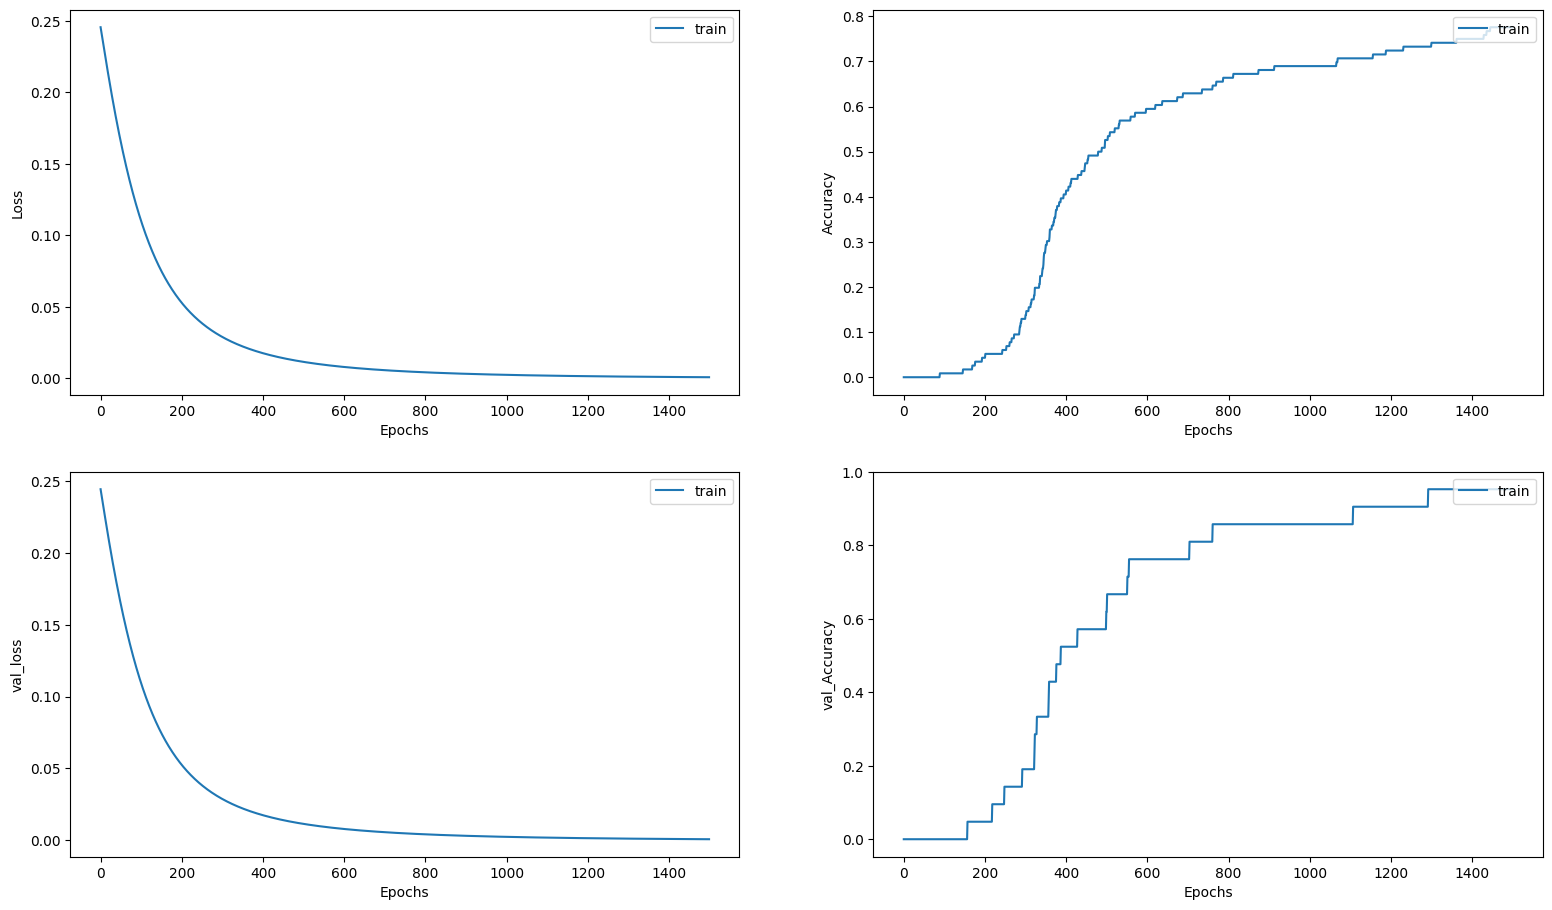

In [38]:
display_learning_curves(history)

In [39]:
%load_ext tensorboard

In [40]:
%tensorboard --logdir logs/fit --host localhost --port 8088

Launching TensorBoard...

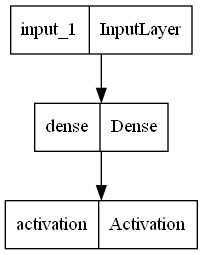

In [41]:
keras.utils.plot_model(model, "my_first_model.png")

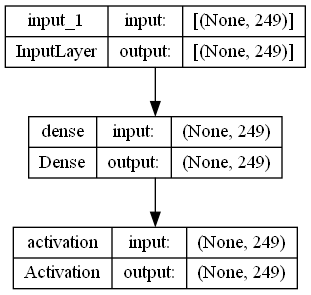

In [42]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [43]:
weights = model.get_weights()
weights

[array([[-1.6109531, -1.5652924, -1.6169606, ..., -1.632551 , -1.4864826,
         -1.6721756],
        [-1.5944725, -1.5112051, -1.6573709, ..., -1.5047871, -1.5854189,
         -1.5594933],
        [-1.6741925, -1.5315906, -1.4976289, ..., -1.5832298, -1.666476 ,
         -1.6738046],
        ...,
        [-1.6775076, -1.5096364, -1.6253048, ..., -1.7061646, -1.6413805,
         -1.5208122],
        [-1.5316466, -1.7033557, -1.5377868, ..., -1.6245897, -1.6040844,
         -1.5468627],
        [-1.6475295, -1.6049258, -1.583725 , ..., -1.585743 , -1.6580677,
         -1.614254 ]], dtype=float32),
 array([-1.8425348, -1.8421342, -1.8439678, -1.8472238, -1.8470582,
        -1.8429097, -1.8378443, -1.840576 , -1.8441064, -1.84265  ,
        -1.8454801, -1.8441639, -1.8405359, -1.8367761, -1.8463532,
        -1.8431505, -1.8400838, -1.8397673, -1.8442359, -1.8421046,
        -1.830039 , -1.8447634, -1.8450023, -1.8440435, -1.8471868,
        -1.847109 , -1.8446492, -1.8286294, -1.8479823

In [44]:
len(weights)

2